<font color='navy'> **DATA8 - Statistics for Machine Learning - part 3** </font>

**Une timeserie, c'est quoi ?**
Tout simplement, un dataset dont les valeurs sont mesurées à différents points dans le temps.
Comme il s’agit d’évaluer l’évolution d’un phénomène au cours du temps, l’ordre est ici très important.

**Pourquoi une partie dédiée aux séries temporelles ?**
- Elles sont présentes dans de nombreux domaines d’application
- Elles permettent de comprendre les tendances passées / d'estimer les comportements futurs

Pandas offre tout un panel d'outils qui simplifient énormément la manipulation de séries temporelles

**Ressources:**
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
- https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

**What you will see today: Timeseries analysis**
1. Basics of timeseries with Pandas
2. Identifying Patterns in Time Series: Trend, seasonality, noise
3. Autocorrelation
4. Spectral analsis (fft)

In [1]:
from IPython.display import Image

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 3

# Travailler avec des timestamps

**TODO**
        
- Charger les données précédentes.  
- Se familiariser avec les outils de Pandas dédiés à la manipulation des dates:
    - https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
    - les méthodes: to_datetime, date_range, period_range, timedelta_range, min, max, shift, resample, rolling, ...
    - la gestion des timezone: tz_localize, tz_convert
    - les offsets

## Charger les données

In [4]:
from os import listdir
def create_datetime_index(df):
    df['DateTime'] = pd.to_datetime(df['Date'].map(str) + ' ' + df['Heures'].map(str))
    df.drop(['Date', 'Heures'], axis=1, inplace=True)
    df.set_index('DateTime', inplace=True)
    return 

def read_rte_file(file_name):
    df = pd.read_csv(file_name, encoding='ISO-8859-1', sep='\t', index_col=None, header=None, skiprows=1, na_values='ND')
    df.drop(df.columns[-1], axis=1, inplace=True)
    df_titles = pd.read_csv(file_name, encoding='ISO-8859-1', sep='\t', index_col=None, nrows=0)
    df.columns = df_titles.columns
    return df

DATA_FILE = 'data/data_rte/'

files = [f for f in listdir(DATA_FILE) if f.startswith('eCO2mix_RTE_Annuel-Definitif')]

df_all = []

for f in files:
    df = read_rte_file(DATA_FILE+f)
    df_all.append(df)
df_all = pd.concat(df_all)
df_all = df_all[(~df_all['Date'].isna())&(~df_all['Heures'].isna())]
create_datetime_index(df_all)
df_all[['Consommation', 'Solaire', 'Eolien']].describe()



,Consommation,Solaire,Eolien
count,157824.000000,157824.000000,157824.000000
mean,54063.251096,935.886101,2732.550056
std,12042.135937,1453.878944,2329.274944
min,29124.000000,0.000000,21.000000
25%,44891.750000,0.000000,1090.000000
50%,52422.000000,13.000000,1984.000000
75%,62303.250000,1509.000000,3615.000000
max,102098.000000,7551.000000,13552.000000


In [5]:
def read_data_entsoe(file):
    df = pd.read_csv(file)
    df['start'], _ = df['MTU (UTC)'].str.split(' - ', 1).str
    df.set_index('start', inplace=True)
    df.index = pd.to_datetime(df.index, yearfirst=True)
    df.drop(columns=['MTU (UTC)'], inplace=True)
    return df

In [6]:
DATA_FILE = './data/data entsoe/France/'

def get_prices(folder, col='fr'):
    df_prices = []
    for f in listdir(folder):
        df = read_data_entsoe(folder + f)
        df.columns = [col]
        df_prices.append(df)
    df_prices= pd.concat(df_prices, axis=0)
    return df_prices

df_prices = pd.concat((get_prices('./data/data entsoe/Electricity_price/France/', 'fr'),
                         get_prices('./data/data entsoe/Electricity_price/Germany/', 'ger')), 1)


<ipython-input-5-85f306f5acb8>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['start'], _ = df['MTU (UTC)'].str.split(' - ', 1).str


## Convertir des dates en Timestamps

In [7]:
pd.to_datetime('2018-01-15 3:45pm')
pd.to_datetime('7/8/1952')
pd.to_datetime('7/8/1952', dayfirst=True)
pd.to_datetime(['2/25/10', '8/6/17', '12/15/12'], format='%m/%d/%y')
pd.to_datetime("4th of July, 2015")

Timestamp('2015-07-04 00:00:00')

In [8]:
pd.date_range('2015-07-03', periods=8, freq='H')
pd.period_range('2015-07', periods=8, freq='M')
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00', '0 days 05:00:00',
                '0 days 06:00:00', '0 days 07:00:00', '0 days 08:00:00',
                '0 days 09:00:00'],
               dtype='timedelta64[ns]', freq='H')

## La classe DatetimeIndex

https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DatetimeIndex.html

### Travailler avec des times zone

In [9]:
df_all = df_all.loc[df_all.index.notnull()]
df_prices = df_prices.loc[df_prices.index.notnull()]
df_prices = df_prices.sort_index()

In [10]:
df_prices_not_tz= df_prices.copy()
df_nat=df_all.copy().sort_index()
df_prices_tz = df_prices.tz_localize('UTC').tz_convert('Europe/Paris').dropna() #
df_nat_tz = df_nat.tz_localize('Europe/Paris', ambiguous = 'NaT', nonexistent='NaT').dropna()


In [11]:
df_prices_tz = df_prices_tz.loc[df_prices_tz.index.notnull()]
df_nat_tz = df_nat_tz.loc[df_nat_tz.index.notnull()].sort_index().dropna()
df_prices_tz=df_prices_tz.sort_index().dropna()
df_prices = df_prices.sort_index()
print(df_prices_tz.index.is_monotonic)
df_prices.index.is_monotonic

True


True

## Interpolation

**TODO**

- Les données de consommation sont fournies toutes les 30 minutes, alors que celles en J-1 sont fournies tous les 1/4 d'heures. Utiliser les différentes fonction d'interpolation offertes par Pandas et ploter le résultat.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html <br/>
https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/#:~:text=Interpolation%20is%20mostly%20used%20while,the%20mean%20of%20the%20month

In [12]:
df_nat.interpolate()

,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,...,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,France,Données définitives,58315.0,58200.0,58200.0,492.0,25.0,3816.0,52697.0,3588.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:15:00,France,Données définitives,58315.0,57700.0,57550.0,492.0,25.0,3816.0,52697.0,3588.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:30:00,France,Données définitives,58315.0,57200.0,56900.0,492.0,25.0,3816.0,52697.0,3588.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:45:00,France,Données définitives,57273.0,56200.0,56000.0,492.0,25.0,3825.0,52222.0,3562.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,France,Données définitives,56231.0,55200.0,55100.0,492.0,25.0,3834.0,51747.0,3536.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,France,Données définitives,65592.0,66650.0,66100.0,93.5,8.0,5652.0,50699.0,1169.5,...,5047.5,1771.5,823.0,494.0,292.0,337.0,NaN,NaN,NaN,NaN
2020-12-31 23:00:00,France,Données définitives,66853.0,67500.0,67000.0,94.0,8.0,5731.0,50679.0,1129.0,...,5106.0,2251.0,791.0,496.0,291.0,337.0,NaN,NaN,NaN,NaN
2020-12-31 23:15:00,France,Données définitives,66801.5,67550.0,67100.0,93.5,8.0,5710.5,50658.0,1070.0,...,5109.0,1864.0,703.5,497.5,289.5,334.5,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='DateTime'>

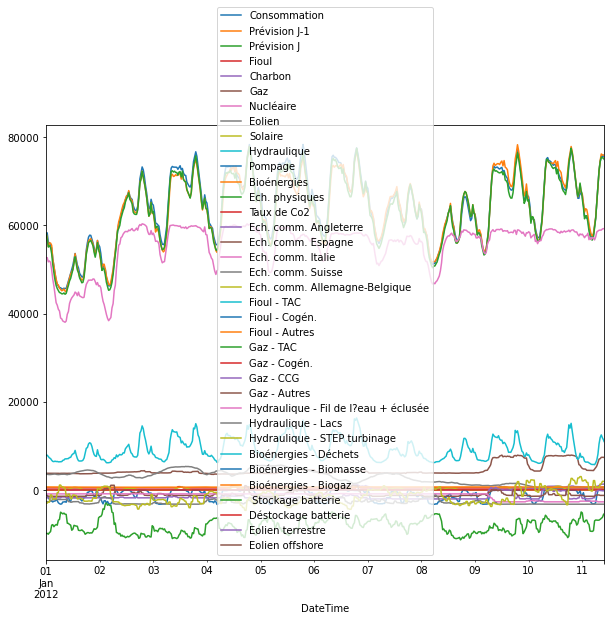

In [13]:
df_nat_int = df_nat.interpolate()
# print(df_nat_int.head())
df_nat_int.iloc[:1000].plot(figsize=(10, 8))

# Identifying paterns in the timeserie

## Trend, saisonality

Série temporelle = Tendance + Saisonnalité(s) + Bruit  <br/>
- Tendance : variations à long terme (tendance nulle = série stationnaire)
- Saisonnalité : variations périodiques
- Bruit : tendance nulle

On cherche ici à extraire la structure du signal, pour, par exemple:
- supprimer la partie bruitage, les erreurs de mesure ou les fluctuations non explicables
- supprimer des variations saisonnières pour évaluer des tendances
- projeter un comportement dans le futur
- ...

**Ressources:**
- un cours théorique: https://perso.math.univ-toulouse.fr/jydauxoi/files/2017/04/poly_eleves.pdf

**TODO**
        
- Observer la courbe de consommation : quelle(s) composante(s) semblent saisonnières ? Quelle tendance ?
- Faire de même avec les sources de production solaire et éolienne.
- Faire apparaitre clairement ces "patterns" en utilisant la méthode "rolling" de Pandas.
- Comparer les méthodes 'rolling' et 'resample'

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html<br/>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

https://towardsdatascience.com/time-series-analysis-resampling-shifting-and-rolling-f5664ddef77e

**Notes pour moi**
- .rolling('W') ne fonctionne pas car toutes les semaines ne sont pas similaires (la semaine peut être coupée à la fin d'année) => .rolling('7d')
- min_periods ne fonctionnera que si la fréquence est toujours exactement la même => resample
- center=True fonctionne si on met un nb de périodes df_temp.rolling(48*7, center=True)
- pour que rolling fonctionne, l'index doit être monotonic (sort_index)

### Décomposition avec rolling mean

#### Observer la courbe de consommation : quelle(s) composante(s) semblent saisonnières ? Quelle tendance ?

<AxesSubplot:xlabel='DateTime'>

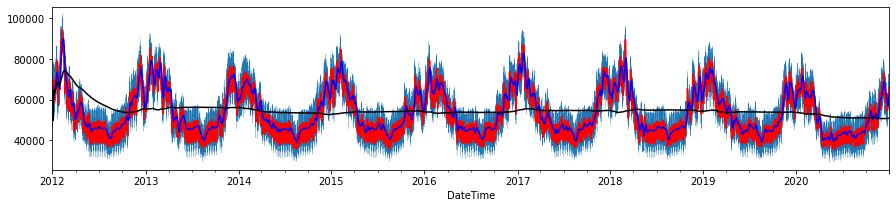

In [14]:
df_nat.Consommation.dropna().plot(linewidth=0.2)
df_nat.Consommation.rolling('1d').mean().plot(color='r')
df_nat.Consommation.rolling('7d').mean().plot(color='b')
df_nat.Consommation.rolling('365d').mean().plot(color='k')

- Saisonalité : plus de consommation de hiver / moins en été
- tendance : semble restée constante

#### Faire de même avec les sources de production solaire et éolienne.

<AxesSubplot:xlabel='DateTime'>

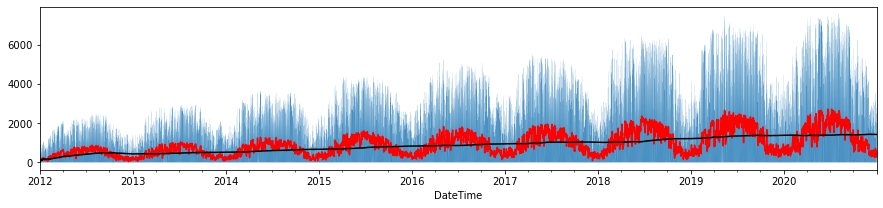

In [15]:
df_nat.Solaire.dropna().plot(linewidth=0.1)
df_nat.Solaire.rolling('1d').mean().plot(color='r')
df_nat.Solaire.rolling('365d').mean().plot(color='k')

<AxesSubplot:xlabel='DateTime'>

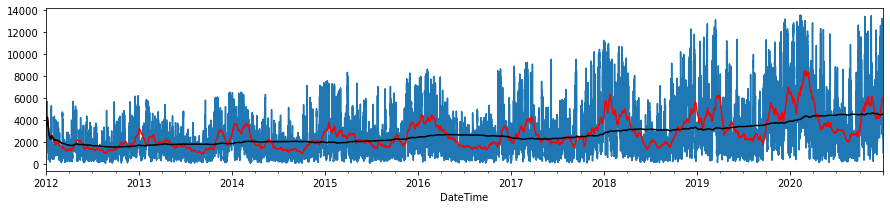

In [16]:
df_nat.Eolien.dropna().plot()
# df_nat.Eolien.rolling('1d').mean().plot(color='r')
df_nat.Eolien.rolling('30d').mean().plot(color='r')
df_nat.Eolien.rolling('365d').mean().plot(color='k')

- Saisonalité qui semble suivre plus ou moins la consommation
- tendance à la hausse au fil des années

### Rolling mean vs resample ...

In [17]:
df_temp = df_nat.Consommation.loc['2015-1':'2015-4'].copy()
df_temp = df_temp.resample('30T').mean()

<AxesSubplot:xlabel='DateTime'>

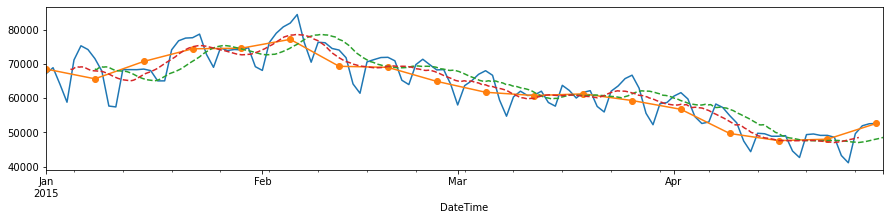

In [18]:
df_temp.resample('1d').mean().plot()
df_temp.resample('7d').mean().plot(marker='o')
df_temp.rolling(48*7).mean().plot(style='--')
df_temp.rolling(48*7, center=True).mean().plot(style='--')

In [19]:
df_temp.head()

DateTime
2015-01-01 00:00:00    74494.0
2015-01-01 00:30:00    73481.0
2015-01-01 01:00:00    71506.0
2015-01-01 01:30:00    71505.0
2015-01-01 02:00:00    71134.0
Freq: 30T, Name: Consommation, dtype: float64

<AxesSubplot:xlabel='DateTime'>

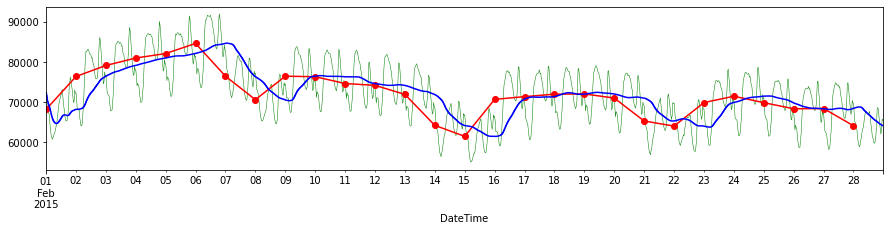

In [20]:
df_temp = df_nat.Consommation.loc['2015-02'].copy()
df_nat.Consommation.loc['2015-02'].interpolate().plot(color="green",linewidth=0.5)
df_temp.resample('1d').mean().plot(marker='o', color ="red")
df_temp.rolling('1d').mean().plot(color ="blue")

<font color='red'>
Ajouter détails observations
    </font>

# Auto-correlation

https://en.wikipedia.org/wiki/Autocorrelation

Une série chronologique est une série de points de données indexés dans le temps. Le fait que les données de séries chronologiques soient ordonnées les rend uniques dans l'espace de données car elles affichent souvent une dépendance sérielle. La dépendance en série se produit lorsque la valeur d'un point de données à un moment donné dépend statistiquement d'un autre point de données à un autre moment. Cependant, cet attribut des données de séries chronologiques viole l'une des hypothèses fondamentales de nombreuses analyses statistiques - que les données sont statistiquement indépendantes.

L'autocorrélation est un type de dépendance en série. Plus précisément, l'autocorrélation se produit lorsqu'une série chronologique est liée de manière linéaire à une version décalée d'elle-même. En revanche, la corrélation est simplement lorsque deux variables indépendantes sont liées linéairement.

**TODO**
        
- Retrouver la cyclicité de la consommation en calculant la corrélation de la courbe de consommation avec une version décalée d'elle même. 

**Bonus**:
- Etudier les corrélations entre le prix et la consommation avec différent décalages temporelles, en été et en hiver, sur les courbes avant et après adaptation de la time zone. Interpréter.

## Consommation

In [21]:
df_autocorr_conso = pd.Series()

for lag in range(-48*7,48*365):
    df_autocorr_conso.loc[lag] = df_nat.Consommation.dropna().autocorr(lag=lag)

<ipython-input-21-6f7806d3e1cb>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_autocorr_conso = pd.Series()


<AxesSubplot:>

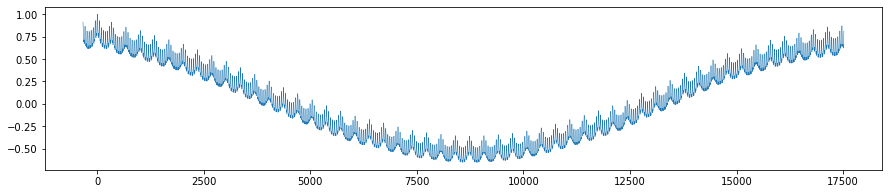

In [22]:
df_autocorr_conso.plot(figsize=(15,3),linewidth=0.5)

<AxesSubplot:>

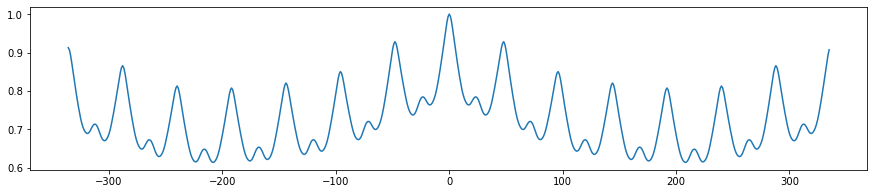

In [23]:
df_autocorr_conso.loc[range(-48*7,48*7)].plot(figsize=(15,3))

## BONUS : lien entre prix et consommation

<ipython-input-24-5a97c6bf581d>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_autocorr_price = pd.Series()


<AxesSubplot:>

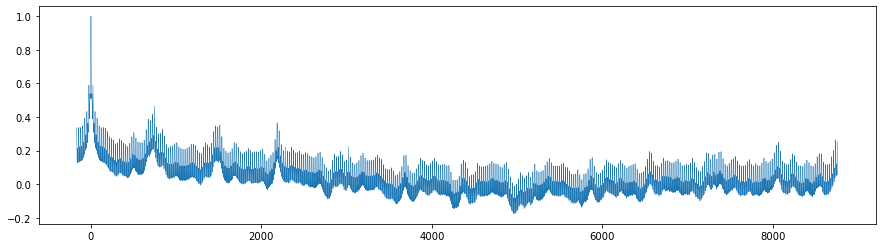

In [24]:
df_autocorr_price = pd.Series()
for lag in range(-24*7,24*365):
    df_autocorr_price.loc[lag] = df_prices.fr.autocorr(lag=lag)
    
df_autocorr_price.plot(figsize=(15,4),linewidth=0.5)

### Recalage courbe de prix

Clairement il y a un décalage d'une heure due à l'heure d'été et l'heure d'hiver : une des deux time series ne tient pas compte de l'heure d'hiver.

De plus, il reste un décalage, pour approfondir, il faudrait aller voir dans les specifications:

- Est ce que la consommation est celle de la demie heure passée?
- Le prix est il un prix instantané?

On peut aussi imaginer que ce décalage correspond au temps qu'il faut pour démarrer des moyens de production rapide comme du gaz : avant que la centrale de gaz ne soit installée, le prix augmente beaucoup car il y a un gros déséquilibre.

<AxesSubplot:>

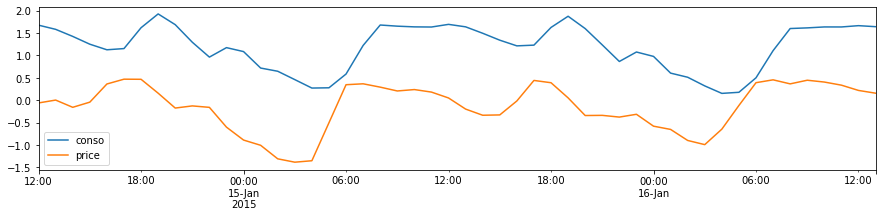

In [25]:
df_ = pd.concat({'conso': df_nat.Consommation, 'price': df_prices.fr}, 1).dropna()
df_ = (df_-df_.mean())/df_.std()
df_.iloc[300:350].plot()

<ipython-input-26-24c69ae7e579>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_shifted_corr = pd.Series()


<AxesSubplot:>

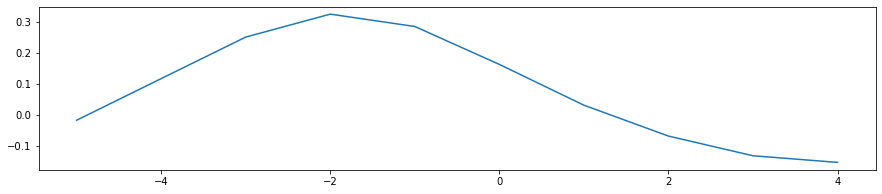

In [26]:
df_ = pd.concat({'conso': df_nat.Consommation, 'price': df_prices.fr}, 1).dropna()
# df_conso_roll = df_all.sort_index().Consommation.rolling('1h').mean()
df_shifted_corr = pd.Series()

# for t in range(-100,24*365):
for t in range(-5,5):
    df_shifted_corr.loc[t] = df_.price.corr(df_.conso.loc['2017-02'].shift(t))
    
# df_shifted_corr.plot(figsize=(15,3))
df_shifted_corr.loc[-24:24].plot(figsize=(15,3))

<ipython-input-27-037b869a836a>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_shifted_corr = pd.Series()


<AxesSubplot:>

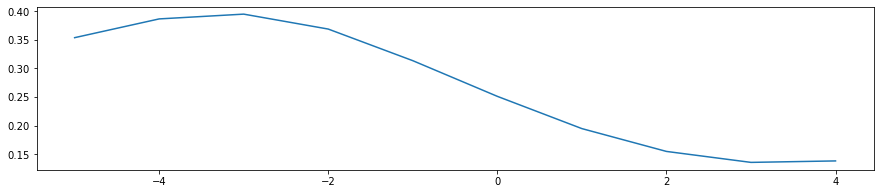

In [27]:
# df_conso_roll = df_all.sort_index().Consommation.rolling('1h').mean()
df_shifted_corr = pd.Series()

# for t in range(-100,24*365):
for t in range(-5,5):
    df_shifted_corr.loc[t] = df_.price.corr(df_.conso.loc['2017-08'].shift(t))
    
# df_shifted_corr.plot(figsize=(15,3))
df_shifted_corr.loc[-24:24].plot(figsize=(15,3))

<ipython-input-28-346496b1efbe>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_shifted_corr = pd.Series()


<AxesSubplot:>

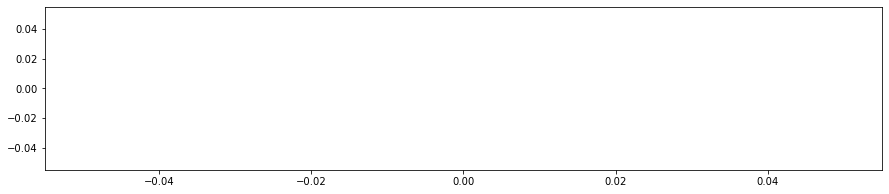

In [28]:
df_tz = pd.concat({'conso': df_nat_tz.Consommation, 'price': df_prices_tz.fr}, 1).dropna()
# df_conso_roll = df_all.sort_index().Consommation.rolling('1h').mean()
df_shifted_corr = pd.Series()

# for t in range(-100,24*365):
for t in range(-5,5):
    df_shifted_corr.loc[t] = df_tz.price.corr(df_tz.conso.loc['2017-02'].shift(t))
    
# df_shifted_corr.plot(figsize=(15,3))
df_shifted_corr.loc[-24:24].plot(figsize=(15,3))

<ipython-input-29-9fbaf6318c87>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_shifted_corr = pd.Series()


<AxesSubplot:>

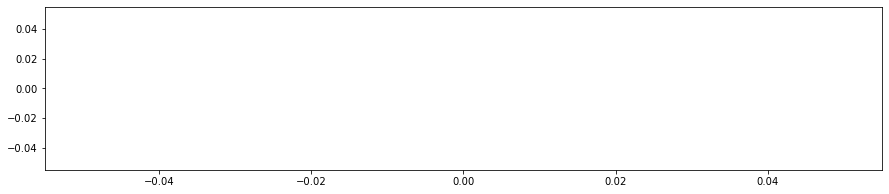

In [29]:
df_tz = pd.concat({'conso': df_nat_tz.Consommation, 'price': df_prices_tz.fr}, 1).dropna()
# df_conso_roll = df_all.sort_index().Consommation.rolling('1h').mean()
df_shifted_corr = pd.Series()

# for t in range(-100,24*365):
for t in range(-5,5):
    df_shifted_corr.loc[t] = df_tz.price.corr(df_tz.conso.loc['2017-08'].shift(t))
    
# df_shifted_corr.plot(figsize=(15,3))
df_shifted_corr.loc[-24:24].plot(figsize=(15,3))

# Etude fréquentielle

**Note:** <br/>
Cette étude fréquentielle n'est pas propre aux séries temporelles : on peut par exemple chercher des fréquences (motifs) dans une image.


**TODO**
        
- Quelles fréquences ressortent de la courbe de consommation ? A quoi correspondent-elles ?
- Tracer le signal obtenu en ne gardant que ces fréquences caractéristiques ? A quel point suffisent-elles pour décrire les variations du signal ?
- Que représentent les hautes fréquences ? Couper les fréquences supérieures à certaines fréquences caractéristiques puis tracer les signaux obtenus.

https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/

## Quelles fréquences ressortent de la courbe de consommation ? A quoi correspondent-elles ?

**Application fft**

L'objectif ici est de détecter les pics afin de lisser les données (tout ça à l'aide d'une transformation de Fourrier)

In [30]:
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt

In [31]:
df_nat.head()

,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,...,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,France,Données définitives,58315.0,58200.0,58200.0,492.0,25.0,3816.0,52697.0,3588.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:15:00,France,Données définitives,NaN,57700.0,57550.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:30:00,France,Données définitives,58315.0,57200.0,56900.0,492.0,25.0,3816.0,52697.0,3588.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:45:00,France,Données définitives,NaN,56200.0,56000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,France,Données définitives,56231.0,55200.0,55100.0,492.0,25.0,3834.0,51747.0,3536.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
fft_conso = fftpack.fft(df_nat.Consommation.dropna().values)
psd_conso = np.abs(fft_conso)**2 # power spectral density

f_s = 48
# freq_conso = fftpack.fftfreq(len(psd_conso), 1/(f_s)) 
freq_conso = fftpack.fftfreq(len(psd_conso))*f_s

# 48 car on souhaite que freq=1 corresponde à 1 jour, et nos données sont par pas de 30 minutes
# f_s = Sampling rate (number of measurements per second pour des résultats en Hz)
# nous on a 48 mesurements par jour

Text(0, 0.5, 'PSD (dB)')

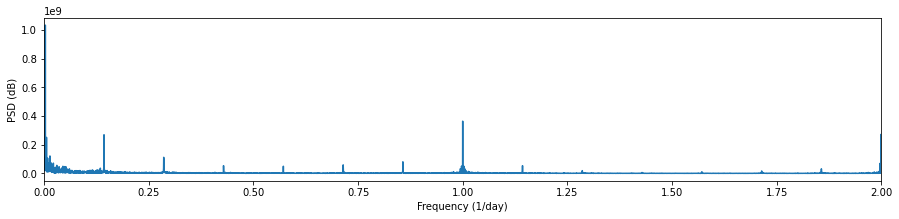

In [33]:
i = freq_conso > 0 # car données réelles donc freq < 0 impossibles

fig, ax = plt.subplots(1, 1, figsize=(15,3))
# ax.plot(freq_conso, 10*np.log10(psd_conso)) # pour avoir des décibels
# ax.plot(freq_conso[i], psd_conso[i])
ax.plot(freq_conso[i], np.abs(fft_conso)[i])
ax.set_xlim(0, 2)
ax.set_xlabel('Frequency (1/day)')
ax.set_ylabel('PSD (dB)')

La fréquence fondamentale du signal est la variation quotidienne de la consommation<br/>
On observe des pics à f=0, f~0.15 f=1, f=2 surtout

In [34]:
# localisation des pics ...
from scipy.signal import find_peaks
# peak_loc, peak_heights = find_peaks(np.abs(fft_conso[i]), height=10**8)
# # localisation des pics (en jours)
# 1/freq_conso[i][peak_loc]
peak_loc, peak_heights = find_peaks(np.abs(fft_conso), height=10**8)
1/freq_conso[peak_loc]

array([ 1.64400000e+03,  3.65333333e+02,  1.82666667e+02,  1.21777778e+02,
        7.30666667e+01,  6.99574468e+00,  3.50159744e+00,  1.00000000e+00,
        5.00000000e-01, -5.00000000e-01, -1.00000000e+00, -3.50159744e+00,
       -6.99574468e+00, -7.30666667e+01, -1.21777778e+02, -1.82666667e+02,
       -3.65333333e+02, -1.64400000e+03])

## Tracer le signal obtenu en ne gardant que ces fréquences caractéristiques ? A quel point suffisent-elles pour décrire les variations du signal ?

In [35]:
fft_peaks_ = np.zeros_like(fft_conso)
fft_peaks_[peak_loc] = fft_conso[peak_loc]
fft_peaks_[0] = fft_conso[0]

fft_peaks = pd.Series(np.real(fftpack.ifft(fft_peaks_)), index=df_nat.Consommation.dropna().index)

<AxesSubplot:xlabel='DateTime'>

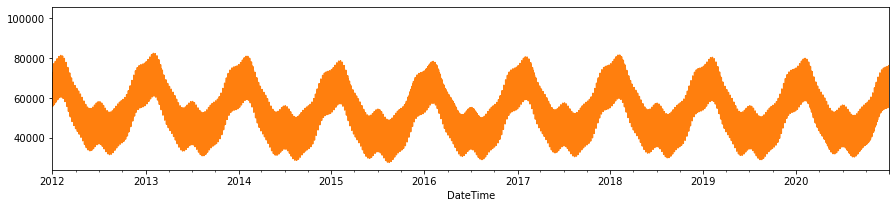

In [36]:
ax = df_nat.Consommation.plot(lw=.5, figsize=(15,3))
fft_peaks.plot(ax=ax)

<AxesSubplot:xlabel='DateTime'>

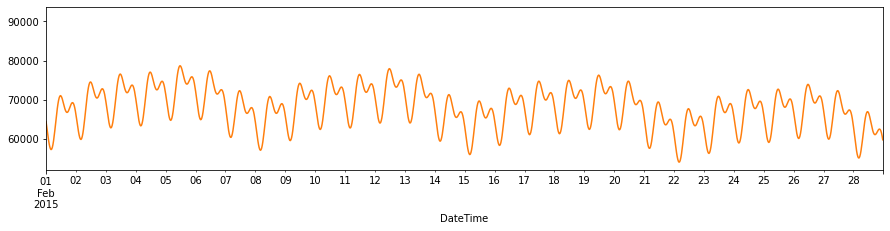

In [37]:
ax = df_nat.Consommation.loc['2015-02'].plot(lw=.5, figsize=(15,3))
fft_peaks.loc['2015-02'].plot(ax=ax)

## Que représentent les hautes fréquences ? Couper les fréquences supérieures à certaines fréquences caractéristiques puis tracer les signaux obtenus.

**On garde ttes les fréquences < 1 an, 1 semaine, 1 jour, ...**

On effectue une FFT inverse pour reconvertir la transformée de Fourier modifiée dans le domaine temporel. De cette façon, on récupère un signal qui contient majoritairement la fréquence fondamentale

In [38]:
fft_cut = pd.DataFrame(index=df_nat.Consommation.dropna().index)

fft_conso_7 = fft_conso.copy()
fft_conso_7[np.abs(freq_conso) > 1/6.9] = 0
fft_cut['7 days'] = np.real(fftpack.ifft(fft_conso_7))

fft_conso_365 = fft_conso.copy()
fft_conso_365[np.abs(freq_conso) > 1/364] = 0

fft_cut['365 days'] = np.real(fftpack.ifft(fft_conso_365))

<AxesSubplot:xlabel='DateTime'>

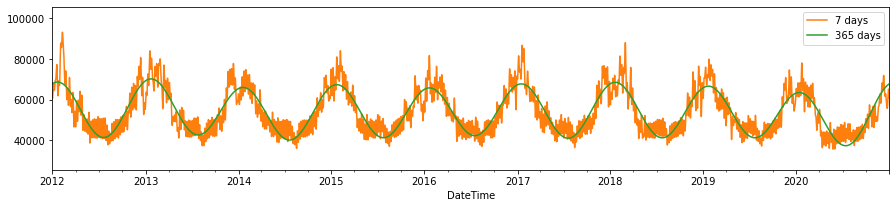

In [39]:
ax = df_nat.Consommation.plot(lw=.5, figsize=(15,3))
# ne s'affiche pas car NA > permet de mieux voir les deux autres jeux de données
fft_cut.plot(ax=ax)

Les hautes fréquences correspondent aux variations rapides.<br/>
On obtient une version lissée du signal, car les variations rapides ont été perdues lorsque nous avons supprimé les hautes fréquences dans la transformée de Fourier

<AxesSubplot:xlabel='DateTime'>

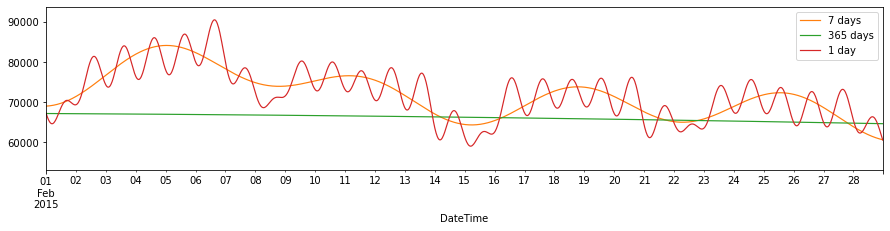

In [40]:
# on coupe les fréquences > 1/(1 jour)

fft_conso_1 = fft_conso.copy()
fft_conso_1[np.abs(freq_conso) > 1.01] = 0
fft_cut['1 day'] = np.real(fftpack.ifft(fft_conso_1))

ax = df_nat.Consommation.loc['2015-02'].plot(lw=.9, figsize=(15,3))
fft_cut.loc['2015-02'].plot(ax=ax, lw=1.2)

# Bonus : Etude des consommations

**TODO**

- Tracer les consommations des différentes années les une sur les autres
- Tracer toutes les consommations journalières les unes sur les autres, pour faire apparaitre des différences de comportement entre : jours de semaine et weekend, jours d'été et d'hiver

## Variations entre années

<AxesSubplot:xlabel='DateTime'>

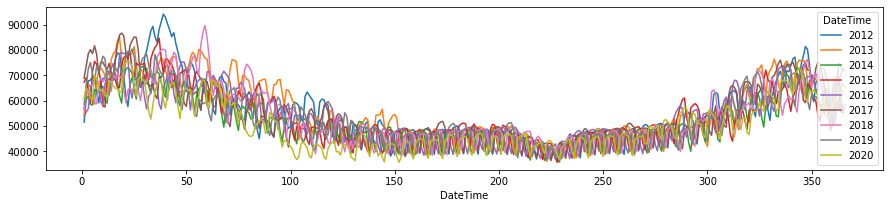

In [41]:
df_nat.pivot_table(index=df_nat.index.dayofyear, columns=df_nat.index.year,
                    values='Consommation', aggfunc='mean').plot()

# df_nat.pivot_table(
#     index = df_nat.index.map(lambda x: x + pd.DateOffset(year=2013)), 
#     columns = df_nat.index.year, 
#     values='Consommation', 
#     aggfunc='mean').rolling('7d').mean().plot()

## Variations entre jours de la semaine / saison

In [42]:
def superpose_days(df):
    return df.pivot_table(
        index = df.index.time, 
        columns = df.index.day,
        values='Consommation', aggfunc='mean')

<AxesSubplot:xlabel='time'>

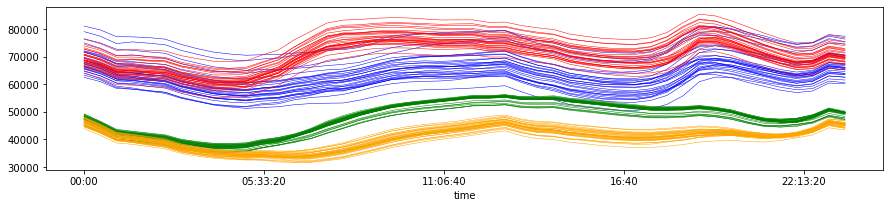

In [43]:
df_weekend_fev = df_nat[(df_nat.index.dayofweek > 4) & (df_nat.index.month == 2)]
ax = superpose_days(df_weekend_fev).plot(color='b', linewidth=0.5, legend=False)

df_weekday_fev = df_nat[(df_nat.index.dayofweek < 5) & (df_nat.index.month == 2)]
superpose_days(df_weekday_fev).plot(color='r', linewidth=0.5, legend=False, ax=ax)

df_weekday_jul = df_nat[(df_nat.index.dayofweek < 5) & (df_nat.index.month == 7)]
superpose_days(df_weekday_jul).plot(color='g', linewidth=0.5, legend=False, ax=ax)

df_weekend_jul = df_nat[(df_nat.index.dayofweek > 4) & (df_nat.index.month == 7)]
superpose_days(df_weekend_jul).plot(color='orange', linewidth=0.5, legend=False, ax=ax)

# Bonus : suite

**TODO**
        
- Comment estimer très simplement la consommation du lendemain ? quelle erreur commet-on ?
- Estimer le taux de production solaire + éolienne dans les années à venir
- Y a-t-il une saisonnalité dans les moyens de productions ?
- Y-a-il une saisonnalité dans les échanges commerciaux entre la France et ses voisins ?
- Quels types de centraleS permettent des changements de production rapides ?

<font color='red'>
Ajouter réponses
    </font>